Looking in indexes: https://download.pytorch.org/whl/cu118


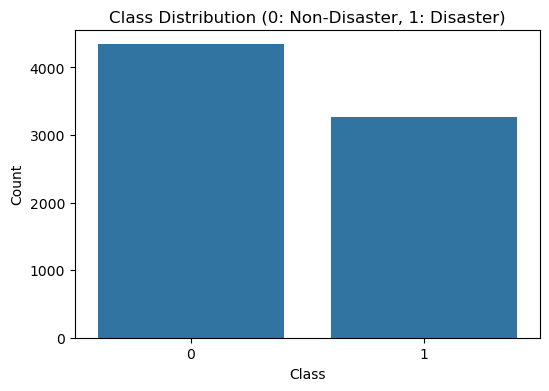

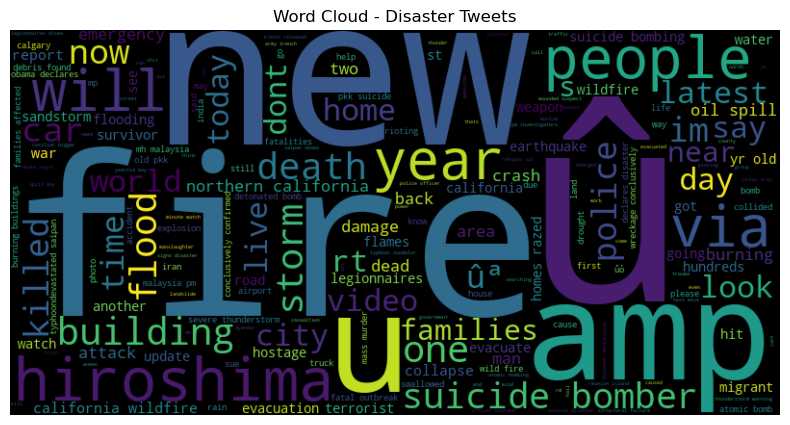

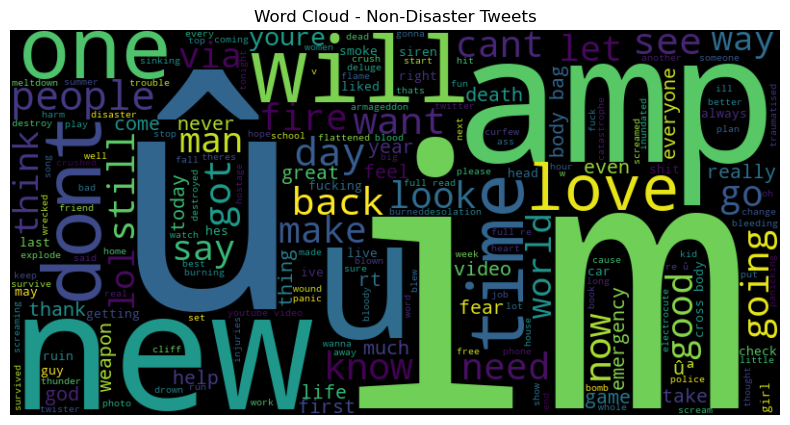

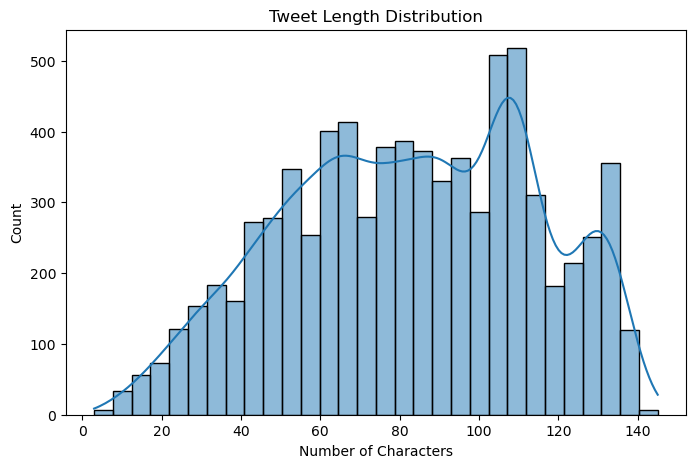

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 0.4498


In [ ]:

# BERT deep learning models 
# use pca model


# Install Required Libraries
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install wordcloud scikit-learn transformers datasets matplotlib seaborn tqdm pandas

# Suppress Hugging Face symlink warnings
import os
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

# Import Required Libraries
import torch
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW

# Define Device (Use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load Dataset
df = pd.read_csv("train.csv")

def clean_text(text):
    text = text.lower().strip()  # Convert to lowercase and strip spaces
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return text

df["clean_text"] = df["text"].apply(clean_text)

# Plot Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df["target"])
plt.title("Class Distribution (0: Non-Disaster, 1: Disaster)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Generate Word Clouds
def generate_wordcloud(data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(" ".join(data))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()

generate_wordcloud(df[df["target"] == 1]["clean_text"], "Word Cloud - Disaster Tweets")
generate_wordcloud(df[df["target"] == 0]["clean_text"], "Word Cloud - Non-Disaster Tweets")

# Tweet Length Distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["clean_text"].apply(len), bins=30, kde=True)
plt.title("Tweet Length Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Count")
plt.show()

# Train-Test Split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["clean_text"], df["target"], test_size=0.2, random_state=42
)

# Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_texts(texts):
    return tokenizer(
        texts.tolist(),
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )

train_encodings = tokenize_texts(train_texts)
val_encodings = tokenize_texts(val_texts)

# Create Dataset Class
class DisasterTweetDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels.values, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}, self.labels[idx]

# Create DataLoaders
train_dataset = DisasterTweetDataset(train_encodings, train_labels)
val_dataset = DisasterTweetDataset(val_encodings, val_labels)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Load Pretrained BERT Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

# Define Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training Loop
EPOCHS = 3
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        inputs = {key: val.to(device) for key, val in inputs.items()}
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

# Save Model
torch.save(model.state_dict(), "bert_disaster_tweets.pth")

# Load Model for Evaluation
model.load_state_dict(torch.load("bert_disaster_tweets.pth"))
model.eval()

# Evaluate Model
predictions, true_labels = [], []
with torch.no_grad():
    for batch in val_loader:
        inputs, labels = batch
        inputs = {key: val.to(device) for key, val in inputs.items()}
        labels = labels.to(device)
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        labels = labels.cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels)

accuracy = accuracy_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation F1 Score: {f1:.4f}")
